# Extract building outlines using scikit-image.
### Skimage: 
From skimage: 
"scikit-image is a collection of algorithms for image processing. It is available free of charge and free of restriction. We pride ourselves on high-quality, peer-reviewed code, written by an active community of volunteers."

To analyze how Skimage functions work, building outline extractions using different skimage functions will be used to explore their use. 

### Includes:
    1. Thresholding
     -color.rgb2gray
     -morphology.remove_small_objects
    
    2. Canny edge detection
    -feature.canny
  
    3. Thresholding+canny+contour
    -exposure.equalize_hist
    -morphology.remove_small_holes
    -measure.find_contours


## Dependencies 


In [16]:

import os
import skimage 
import numpy as np 
import geopandas as gpd 
import pandas as pd
import rasterio 
from rasterio import plot 
import matplotlib.pyplot as plt 
import skimage.io as io
from scipy import ndimage as ndi 
from skimage.util import random_noise
from skimage import feature
import skimage.filters as filters
from skimage.feature import canny
import skimage.color 
from skimage import morphology, measure, draw


## Displaying our image
### Before we start
We will be working with .jp2 imagery which is commonly seen with the sentinel 2 satellite. Where you see "rasterio.open(file name)", put the name of the .jp2 image to be processed.
To ensure it is in the right place, use os.getcwd() to see where your computer will be looking when you call this method. 

To start, let's try displaying our image so we know what to work with.


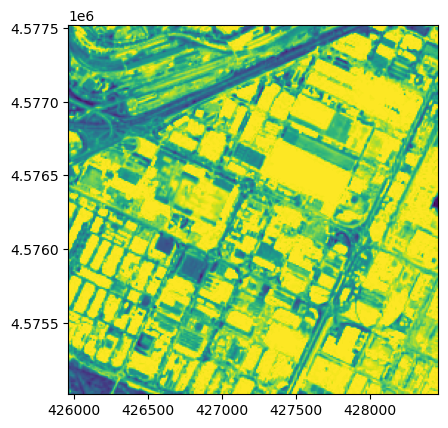

<Axes: >

In [19]:
rasterio.plot.show(rasterio.open('subset.jp2')) 

In [20]:
type(rasterio.open('subset.jp2'))

rasterio.io.DatasetReader

Rasterio is able to read and display the image directly. The .open file creates a DatasetReader object that the .show function can read. 
The DatasetReader object organizes the image as (channels, rows, columns).


However we will be using skimage's display functions, not Rasterio. Lets see how skimage will handle the image file.

To preface, Skimage's displaying functions extend off of Matplotlib’s displaying function.





In [21]:
#plt.imshow(rasterio.open('T31TDF_20230517T103629_TCI_10m.jp2'))
#plt.show()


## How it works
not all packages read image data the same, skimage is seemingly unable to comprehend the image.

This is because Skimage and Matplotlib read in Numpy arrays - not Rasterio’s DatasetReader object.  Furthermore, the DatasetReader object is an array in the shape of (channels, rows, columns). Due to this, even if Skimage and Matplotlib could read the array, it would still cause an error due to the fact that Matplotlib and skimage display images in the shape of (rows, columns, channels). 

To fix this, we must make the data a Numpy array that is also in the appropriate dimensions of (rows, columns, channels).

Then, we will be able to display our image and manipulate it.
### Converting from jp2 to Numpy array
Rasterio has a .read function that converts image files into numpy arrays. 
We can separate our color bands by simply reading the first dimensions of the DatasetReader object.

To be able to display the image with Skimage the individual bands, now in Numpy array form, must be stacked into a 3D Numpy Array.


In [22]:
with rasterio.open('subset.jp2') as opn:  # opn = DatasetReader object
    one = opn.read(1)   # First
    two = opn.read(2)   # Second
    three = opn.read(3)  # Third

In [23]:
type(three) # Individual bands are now Numpy arrays instead of DatsetReader

numpy.ndarray

In [24]:
three.shape# 2D

(250, 250)

Now we no longer have a 3D array as we individualized our channels. 

Skimage and Matplotlib can now display these, but the functions will not know what colormap to use.

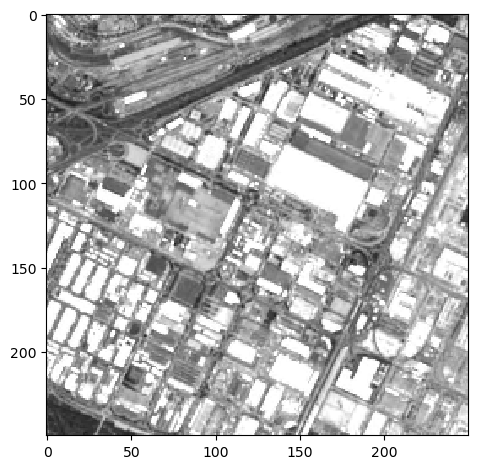

In [25]:
io.imshow(three) # Supplement "three" with "one" and "two" to see the different layers.
io.show() # skimage's display function

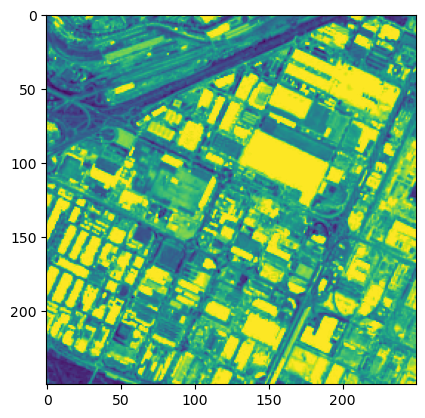

In [26]:
plt.imshow(three) # supplement "three" with "one" and "two" to see the different layers.
plt.show() # matplotlib's display function 

If you display the different bands you can see that they all are the same colormap.

Since the shape of the image is only (rows, column), as a result of reading each band individually, Matplotlib (and by extension, Skimage) will display the image with a default color map as the functions are not provided with one. 


To properly display the image and recognize the channels, the individual 2d numpy arrays must be restacked on top of eachother. This will add the 3rd dimension that Skimage uses to identify channels. 


In [27]:
with rasterio.open('subset.jp2') as src:
    red = src.read(1, masked=True)
    green = src.read(2, masked=True)
    blue = src.read(3, masked=True)

In [28]:
rgb_image = np.stack([red, green, blue])  # Restacking images

print(rgb_image.shape)

(3, 250, 250)


The image data is now a 3D Numpy array but it is still in the order of (channels, row, col).

Skimage will not be able to read this as it is not (row, col, channels).

Numpy has a function to pick the axis of which the variables are placed. by making axis=-1, you set the 3 channels of red green and blue to the last axis.


In [29]:

land = np.stack([red, green, blue], axis=-1)  # Restacking images

print(land.shape)

(250, 250, 3)


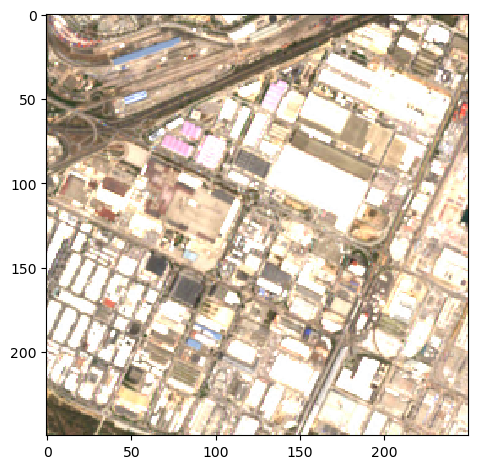

In [30]:
io.imshow(land)
io.show()

Skimage's display function is now appropriately reading our .jp2 image.



## Preparing our image
The image processing methods we will look at commonly rely on grayscale images to further define their edges. 



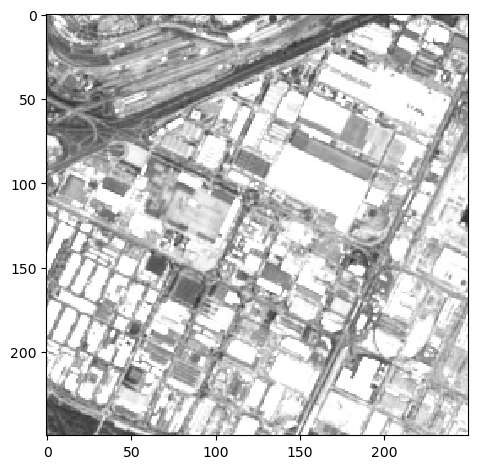

In [32]:

grayland = skimage.color.rgb2gray(land)  # Grayscale
io.imshow(grayland)
io.show()

### Function explanation
 Skimage's grayscale function works without any complex algorithms or equations, just off of human perception. 

When a RGB image’s red, green, and blue values are in the intensity ratio of 0.2125, 0.7154, and 0.0721 respectively, the image appears as gray.

With that in mind, rgb2gray uses this principle to convert every individual pixel with a single equation; it multiplies each value by the ratio and adds them together for the grayscale intensity. Once done, the resulting image is a single channel (single histogram) image.

$ gray = 0.2125 * red + 0.7154 * green + 0.0721 * blue $






# 1.Thresholding 
A threshold function returns a number based on the intensity values of an image. This number can be used to binarily segment an image to foreground and background by setting intensity values above the threshold to white and below to black. 

This method comes with some caveats when applied to object extraction. A single threshold value can be inaccurate at segmenting an image if intensity values are unevenly distributed. This can be solved by adaptive thresholding which thresholds an image in chunks. Another solution is using a different thresholding model as some tailor to a specific scenario. 

When it comes to object extraction, thresholding comes with another issue. Thresholding does not take into account the relationship of pixels and the desired object. As a result, target objects must be distinguishable by their grayscale value to be effectively isolated through thresholding. 




### Examples of different thresholding methods
In this example we will be using triangle thresholding.



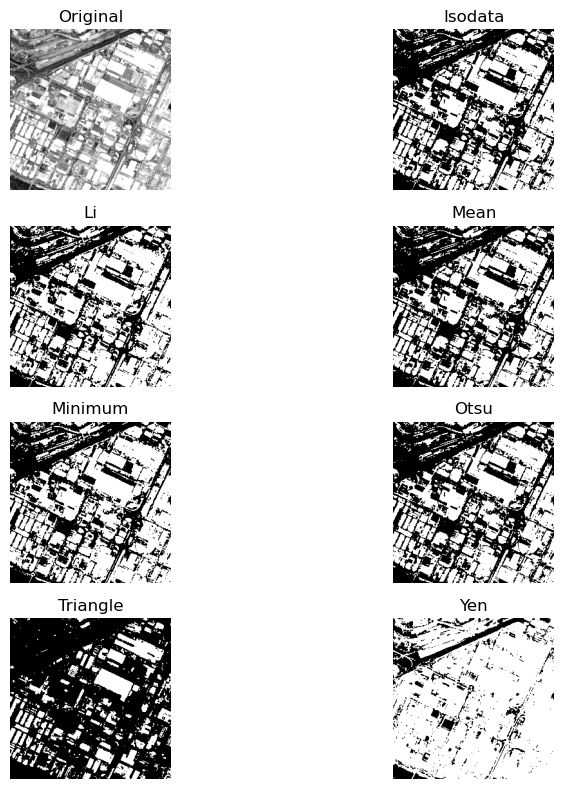

### Function explanation
"filters.threshold_triangle" uses the triangle algorithm to find its threshold. This works by essentially creating a triangle within the histogram. Then, the bar within the triangle that is closest to the midpoint becomes the threshold value. 
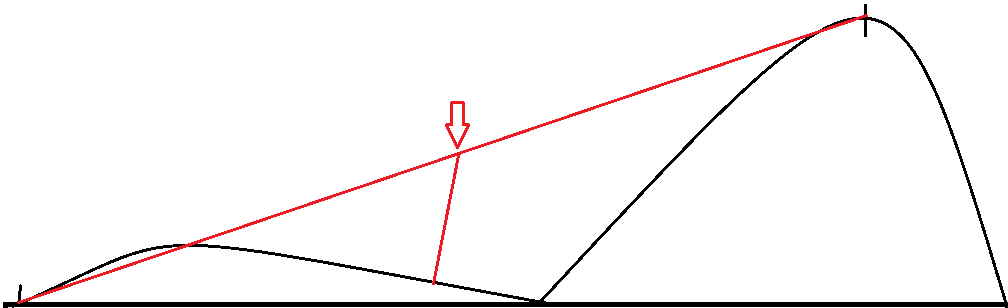

  

In [33]:
threshold_image = filters.threshold_triangle(grayland)
threshold_image

0.9698598383884804

### Now we have our threshold, the value that dictates fore and background
To use this number, we run it through a logic gate. By doing so, we basically set the values that fit above said threshold to "true" while setting the rest to "false". 


In [34]:
# Convert the threshold image to binary
binary_image = np.bitwise_xor(grayland < threshold_image, True) 
binary_image

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ...,  True, False,  True],
       [False, False, False, ...,  True,  True,  True]])

Our image is now binary.

To display our images, we must normalize our data.







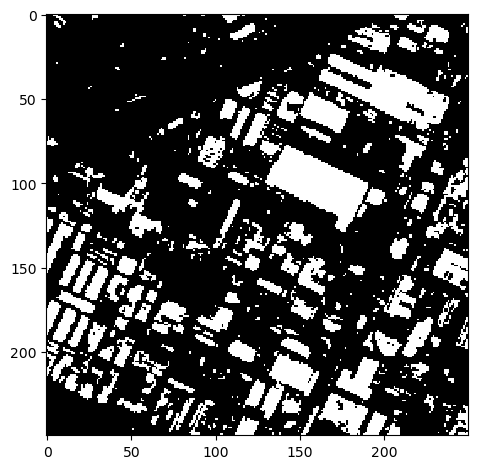

In [35]:
normalized_binary = binary_image.astype(float) # Converts Bool to float 
normalized_binary /= normalized_binary.max()
io.imshow(normalized_binary, cmap = 'gray')
io.show()


### Artifacts
These are errors caused as a byproduct of extraction methods. These can be resolved through pre/post processing or by just using better images. 






In [36]:

# Removes small arifacts 
cleanfinal = skimage.morphology.remove_small_objects(binary_image, 21) # Removes the islands of values set to 1 (white) that have an area of 21

### Function explanation
From the source code, this function works very simply. Omitting the error checks, this function works by:
1. taking binary array 
3. using np.bincount to figure out size of objects (groups of 1's)
4. creates a new mask array that will sort out groups of 1s that are smaller than the given size
5. returns applied mask
Basically, deleting any groups of 1's that are smaller than the threshold provided.


In [38]:
# Normalize the image to ensure its [0-1], 
normalized_image = cleanfinal.astype(float)
normalized_image /= normalized_image.max()

### Final product


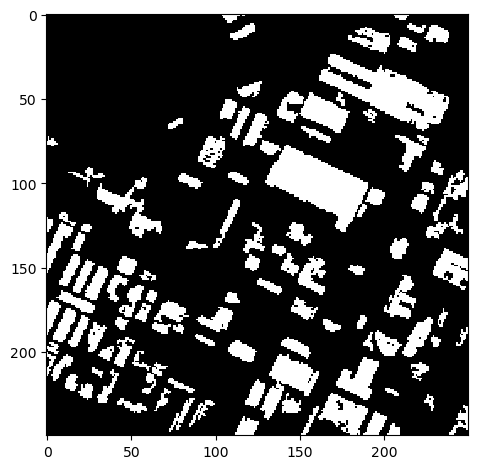

In [39]:
io.imshow(normalized_image, cmap = 'gray')
io.show()

## 2.Canny edge detection

The function is a collection of image processing algorithms that work in a coordinated order to detect edges. 
General structure: 

1.Noise Reduction: Guassian filter.

2.Gradient Calculation: Computing the gradient magnitude and direction of the smoothed image to identify what directions the edges are facing, based on sobel. 

3.Non-maximum Suppression: Nullifies false edges that don't align with the gradient. 

Double Thresholding: Sorts edges based on their threshold and gradient level to isolate weak and strong edges. 

Edge Tracking by Hysteresis: Connecting the weak edge pixels to strong edge pixels with the assumption noise caused siad disconnection. 



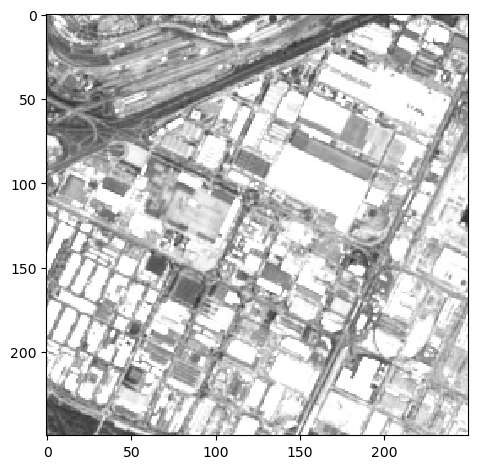

In [40]:
grayland = skimage.color.rgb2gray(land)
io.imshow(grayland)
io.show()

### Getting started
Skiamage comes with its own canny function which will directly give us our outlines. 
The sigma value dictates the standard deviation of the gaussian filter to dictate the degree to which blurring is applied to the image. 





In [41]:
# Two different values of sigma 
edges1 = feature.canny(grayland) 
edges2 = feature.canny(grayland, sigma=2) 
edges1

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False,  True, ..., False, False, False],
       [False, False, False, ...,  True,  True, False],
       [False, False, False, ..., False, False, False]])

Normalize 

In [42]:
edges1 = edges1.astype(np.float32)  # Convert to float
edges1 /= edges1.max()  # Normalize to the range [0, 1]
edges2 = edges2.astype(np.float32)  # Convert to float
edges2 /= edges2.max()  # Normalize to the range [0, 1]

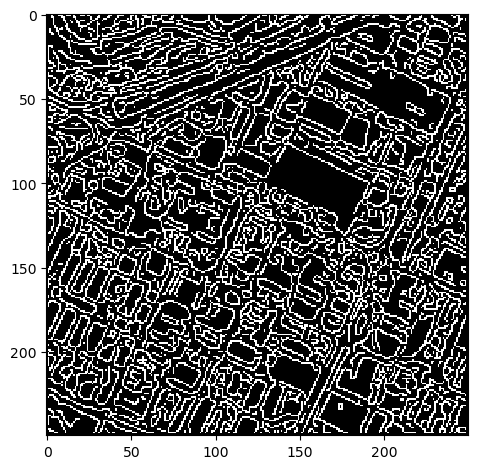

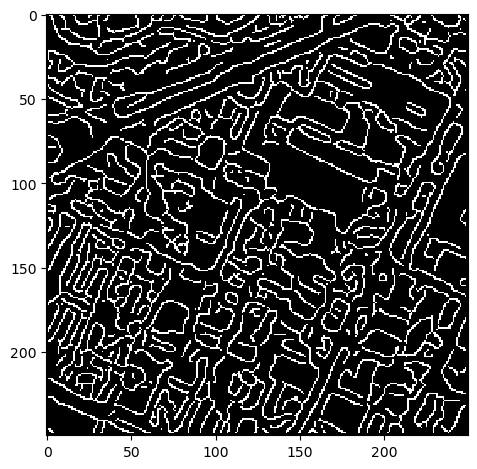

In [43]:
io.imshow(edges1, cmap='gray') # Smaller sigma
io.show()
io.imshow(edges2, cmap='gray') # Larger sigma
io.show()

# Final product
Canny was able to find the building outlines but ended up with many edge detections of irrelevant objects. It might be easy for a human to point out buildings within the edges but any machine will have difficulty consuming this.



## 3.Contour
In this example, all the functions above can be used for a more accurate extraction. 
### Preprocessing


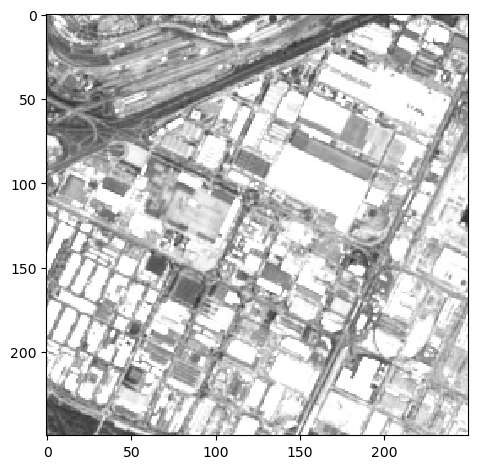

In [44]:
pic = skimage.color.rgb2gray(land)
io.imshow(pic)
io.show()

### Equalize
Our first preprocessing step after rescaling is histogram equalization. This spreads out the intensity values in our histogram so we get greater contrast.



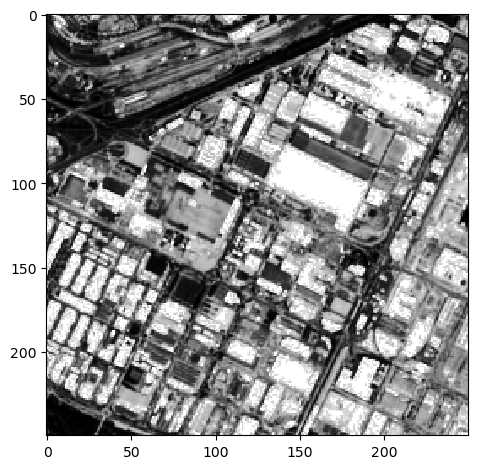

In [45]:
gray_image = skimage.exposure.equalize_hist(pic) 
io.imshow(gray_image)
io.show()

### Function explanation

 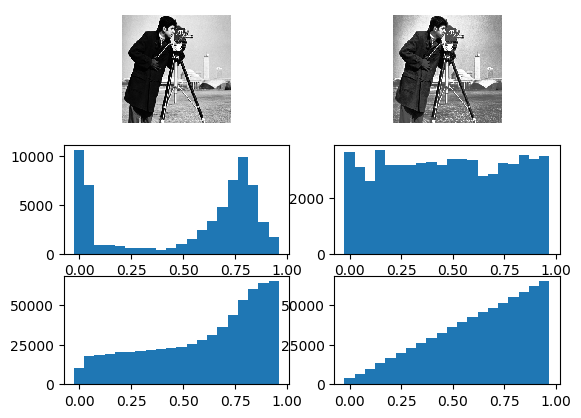
 
 The purpose of the function is to minipulate the intensity values by making the histogram as even as possible.
It uses the cumulative distribution function.
$$ F_{X}(x)=P(X\le x) $$

### Thresholding
The second step is using thresholding. 

Mean thresholding will be used in this instance. This method simply takes the average intensity value of the bins and uses that as the threshold value. 


In [46]:

threshold = skimage.filters.threshold_mean(gray_image) 
threshold

0.5091542247328978

In [47]:
gray_image = gray_image > threshold # Sets values of gray_image that are above threshold to true.
gray_image

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

In [48]:
prepared_pic = gray_image.astype(float) # Converts to numbers
prepared_pic /= prepared_pic.max()
prepared_pic

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

Now gray_image is thresholded and normalized.



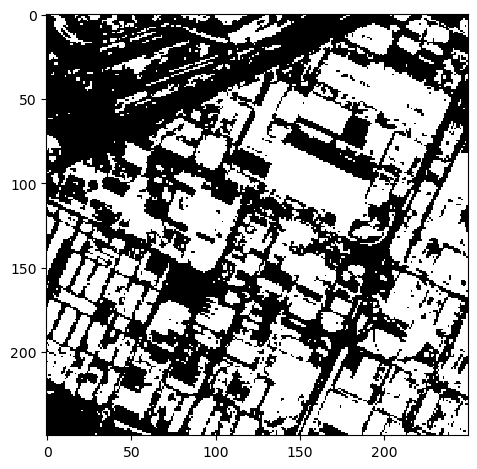

In [49]:
io.imshow(prepared_pic)
io.show()

### More preprocessing
There are morphology methods that can be used to clean up the image. The image has lots of artifacts in the form of random detections and peppers/holes in our outlines. 

In [50]:
gray_image1 = skimage.morphology.remove_small_objects(gray_image, 20) # Adjust number if needed

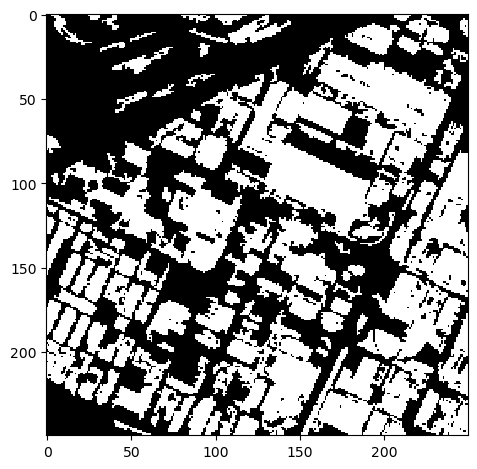

In [51]:
prepared_pic1 = gray_image1.astype(float) # Normalize 
prepared_pic1 /= prepared_pic1.max()
io.imshow(prepared_pic1)
io.show()

### Artifact removal
We still have small holes in our outlines.

We can use morphology.remove_small_holes.







In [52]:
gray_image2 = skimage.morphology.remove_small_holes(gray_image1, 14) # Adjust as needed

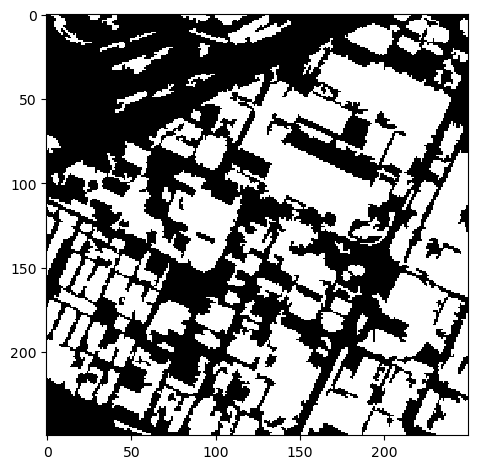

In [53]:
prepared_pic2 = gray_image2.astype(float) #Converts to numbers
prepared_pic2 /= prepared_pic2.max()
io.imshow(prepared_pic2)
io.show()

### Function explanation
The remove_small_holes function works just like the remove_small_object function but with opposite values of focus. 




now, we have our buildings. Canny edge detector should be more accurate with the simplified imagery above.


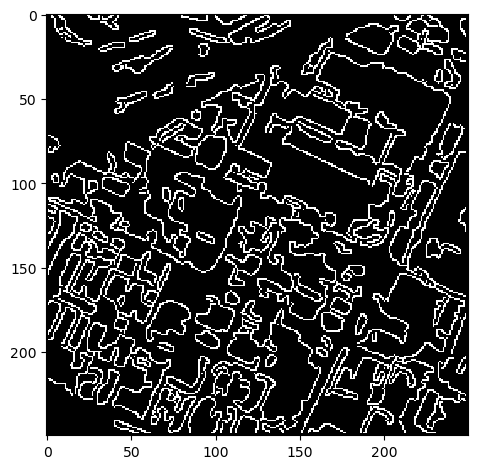

In [54]:
edges = skimage.feature.canny(prepared_pic2, sigma=1.0)
edges = edges.astype(np.float32)  # Convert to float
edges /= edges.max()  # Normalize to the range [0, 1]
io.imshow(edges)
io.show()

### Processing
Now the extractions are more accurate than if we just did canny. For the sake of using more Skimage functions the image can be used to find contours. In short, the countours are the bounds of geometry, in this case, the edges. 


In [55]:
contours = skimage.measure.find_contours(edges)


### Function explanation
find_contour uses the marching squares algorithm to detect contours. It then implements the assemble_contour helper method to connect them. The marching square algorithm essentially breaks down the image into 2x2 squares to assign contours from a case table. Finally, the values are run through linear interpolation to find a more accurate position for the contour.




### Postprocessing
The extractions be overlayed over the base image.

In [56]:
overlay = land.copy() #we will set the base RGB image as our backround

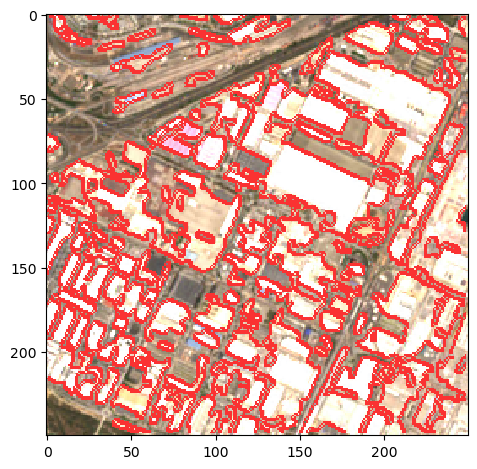

In [57]:
for contour in contours:
    rr, cc = contour[:, 0].astype(int), contour[:, 1].astype(int)
    overlay[rr, cc] = [250, 50, 50]

# Display the overlay image
io.imshow(overlay)
io.show()

Since the canny edges were already the bounds of the buildings, finding the contours of them is pointless. We can eliminate that step and simply plot the contours of the thresholded image.

In [58]:
contours = skimage.measure.find_contours(gray_image2)
# Contours

In [59]:
overlay = land.copy()

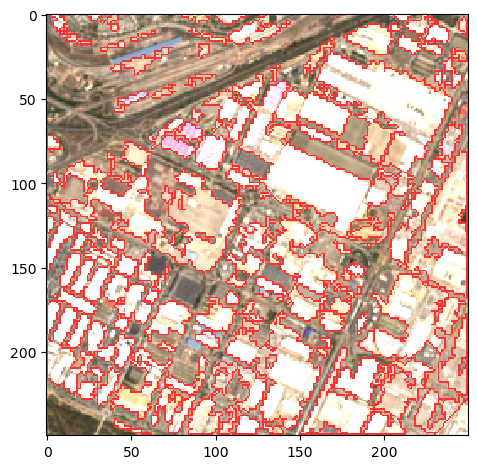

In [60]:


for contour in contours:
    rr, cc = skimage.draw.polygon_perimeter(contour[:, 0], contour[:, 1], overlay.shape[:2])
    overlay[rr, cc] = [250, 50,50]  


io.imshow(overlay)
io.show()


# Reference list 
[1]	“scikit-image’s documentation — skimage 0.21.0 documentation.” https://scikit-image.org/docs/stable/ (accessed Jul. 06, 2023)

[2]	“Reading Datasets — rasterio documentation.” https://rasterio.readthedocs.io/en/stable/topics/reading.html (accessed Jun. 26, 2023).

[3]	“numpy.stack — NumPy v1.25 Manual.” https://numpy.org/doc/stable/reference/generated/numpy.stack.html (accessed Jun. 26, 2023).

[4]	“Auto Threshold,” ImageJ Wiki. https://imagej.github.io/plugins/auto-threshold (accessed Jun. 27, 2023).

[5]	“Cumulative Distribution Function.” https://www.probabilitycourse.com/chapter3/3_2_1_cdf.php (accessed Jun. 27, 2023).

[6]	“Histogram equalization with Python and NumPy.” http://www.janeriksolem.net/histogram-equalization-with-python-and.html (accessed Jun. 27, 2023).

[7]	“Canny edge detector — skimage 0.21.0 documentation.” https://scikit-image.org/docs/stable/auto_examples/edges/plot_canny.html (accessed Jun. 27, 2023).

[8]	“Canny edge detector,” Wikipedia. May 08, 2023. Accessed: Jun. 27, 2023. [Online]. Available: https://en.wikipedia.org/w/index.php?title=Canny_edge_detector&oldid=1153795680

